In [34]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os

In [ ]:
# Get the current working directory
baseFolder = os.getcwd()

# Define the folder containing the images
folder = os.path.join(baseFolder, "photos", "largeBubbles")

# Read the image in grayscale
img = cv.imread(os.path.join(folder, "1.png"),0)

print("Image Shape: ", img.shape)
print("Image min: ", img.min())
print("Image max: ", img.max())

img_shown = cv.resize(img, (600, 800))

# The image with the corners is shown
cv.imshow('Loaded Image', img_shown) # We show the found corners in the image
cv.waitKey(1000)
cv.destroyAllWindows()

# We load the camera calibration results (We took the photos with the first camera setup)
cameraParameters = np.load(baseFolder + "/calibration/camera_setup1.npz")

# We extract the camera matrix and distortion coefficients, through the keys in the dictionary
mtx = cameraParameters['mtx']
dist = cameraParameters['dist']

Image Shape:  (1216, 1936)
Image min:  23
Image max:  255


(np.float64(-0.5), np.float64(1921.5), np.float64(1201.5), np.float64(-0.5))

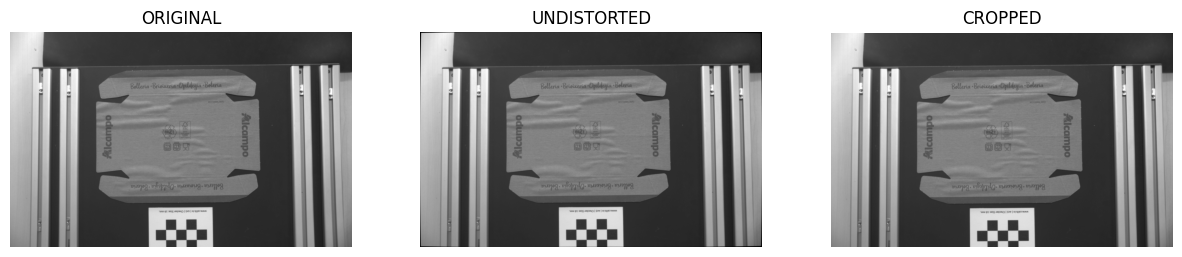

In [42]:
# We find the dimensions of the image
h, w = img.shape[:2]

# We find the new camera matrix and interested region
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

# We undistort the image
udst_img = cv.undistort(img, mtx, dist, None, newcameramtx)

# We crop the image using the ROI
x_r, y_r, w_r, h_r = roi
udst_crop_img = udst_img[y_r:y_r+h_r, x_r:x_r+w_r]

# We show the images
plt.figure(figsize=(15, 10))

plt.subplot(1,3,1)
plt.imshow(img, cmap="gray", vmin=0, vmax=255)
plt.title("ORIGINAL")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(udst_img, cmap="gray", vmin=0, vmax=255)
plt.title("UNDISTORTED")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(udst_crop_img, cmap="gray", vmin=0, vmax=255)
plt.title("CROPPED")
plt.axis("off")

Text(0, 0.5, 'Frequency')

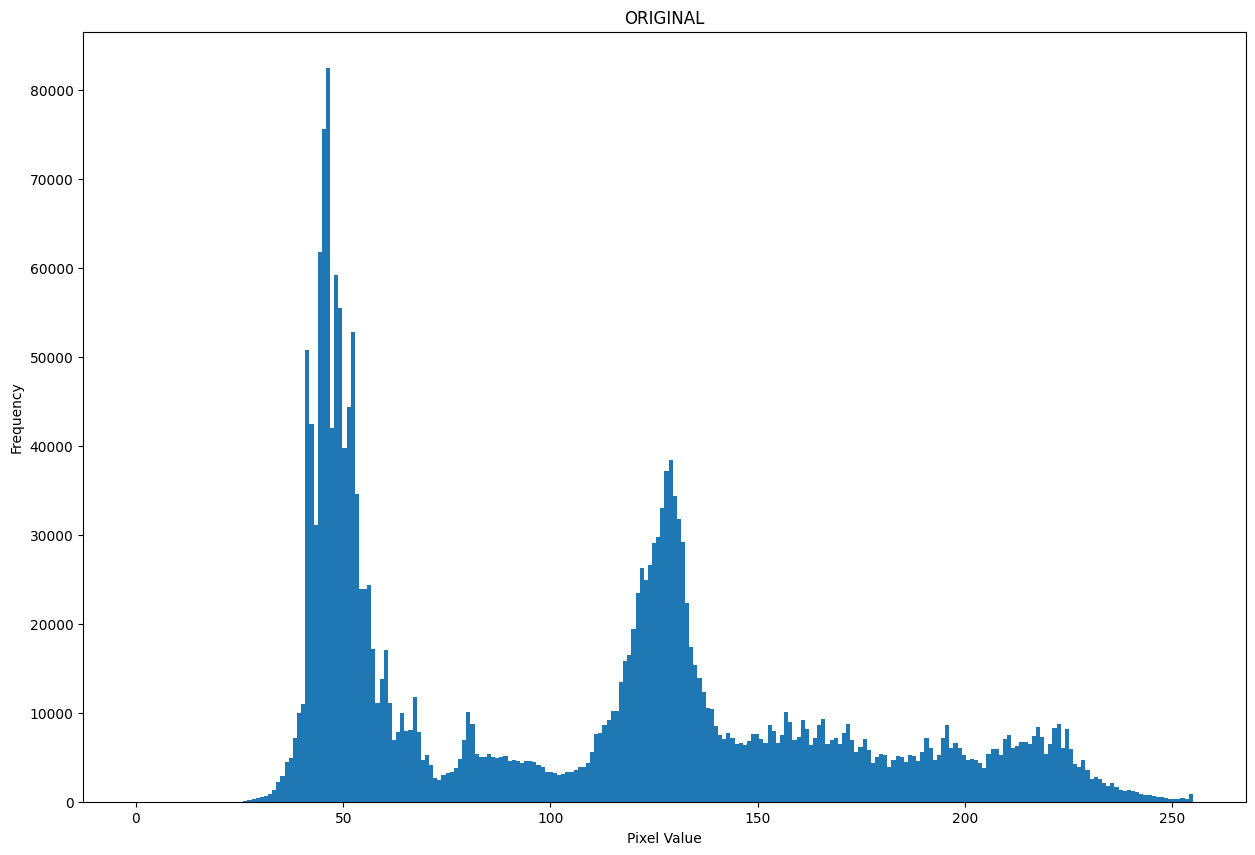

In [37]:
# We show the histogram of the image
plt.figure(figsize=(15, 10))
plt.hist(udst_crop_img.ravel(), bins=256, range=(0, 255))
plt.title("ORIGINAL")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")

(np.float64(-0.5), np.float64(1921.5), np.float64(1201.5), np.float64(-0.5))

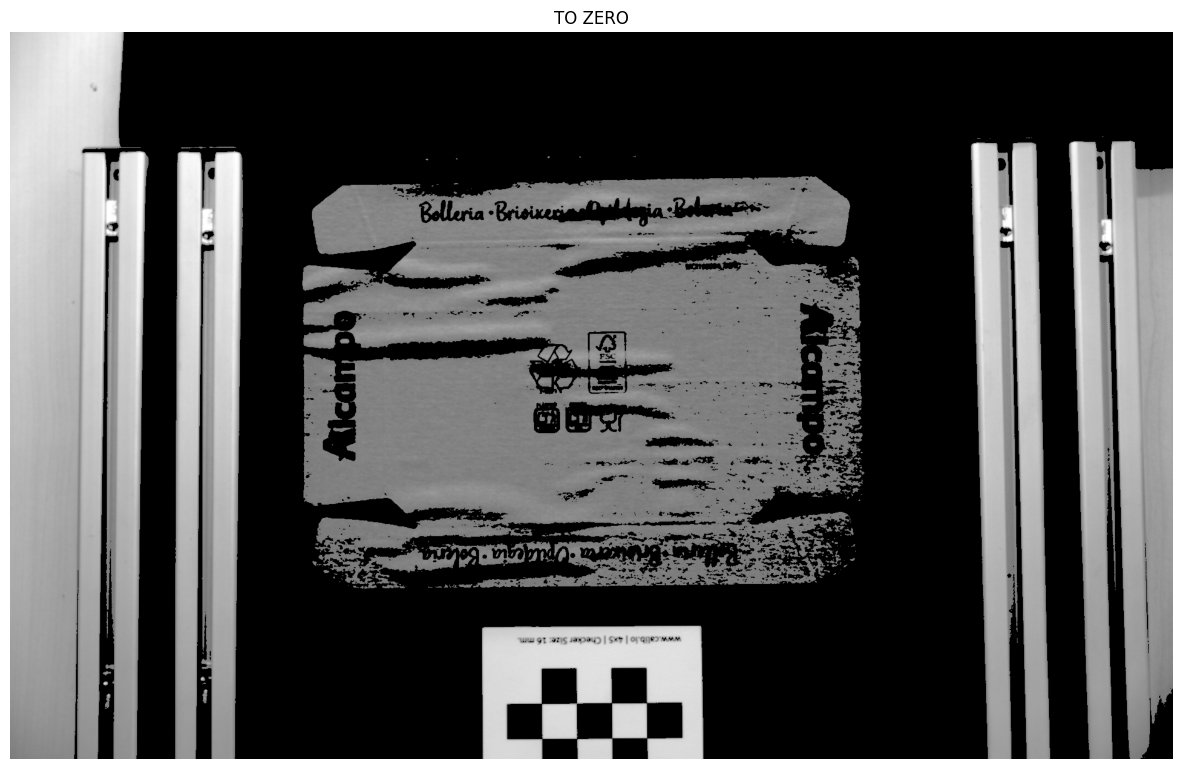

In [38]:
# Thresholding the imnage
thValue = 120
_ , thTOZERO = cv.threshold(udst_crop_img,thValue,255,cv.THRESH_TOZERO)

# Let's see the results
plt.figure(figsize=(15, 10))
plt.imshow(thTOZERO, cmap="gray", vmin=0, vmax=255) # to complete
plt.title("TO ZERO")
plt.axis("off")

(np.float64(-0.5), np.float64(1921.5), np.float64(1201.5), np.float64(-0.5))

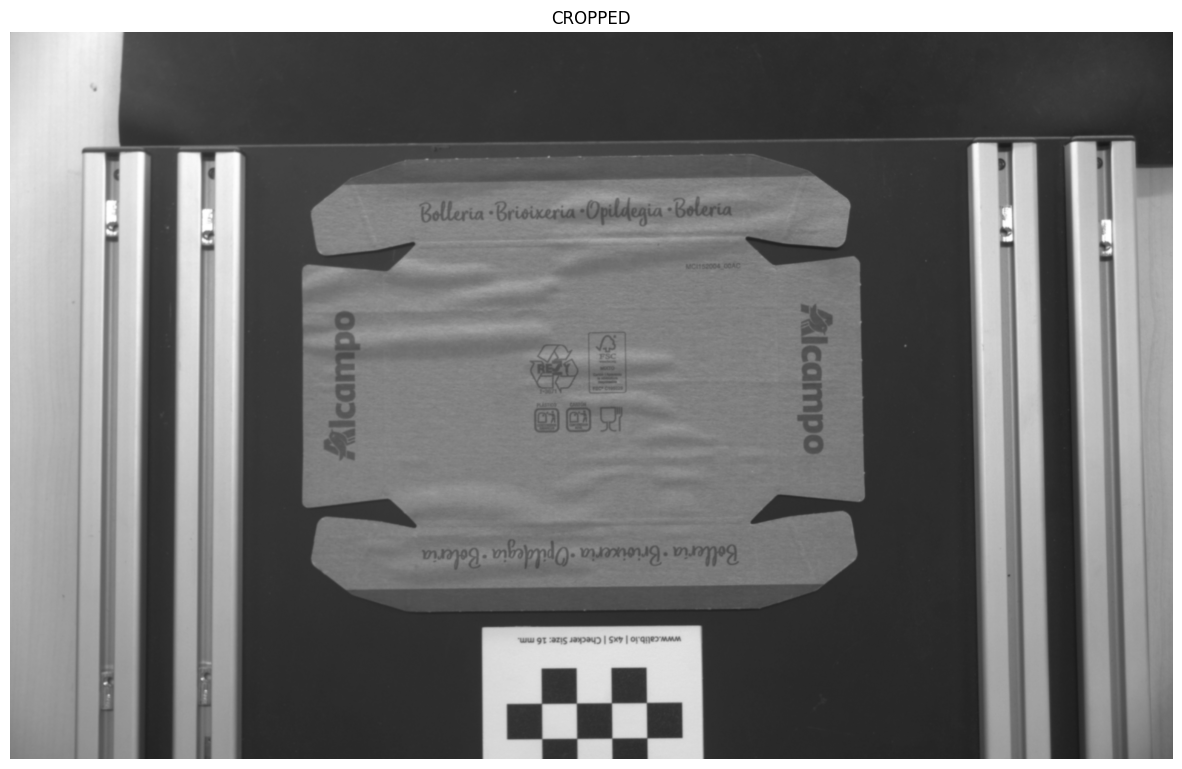

In [39]:
# We show the images
plt.figure(figsize=(15, 10))
plt.imshow(udst_crop_img, cmap="gray", vmin=0, vmax=255)
plt.title("CROPPED")
plt.axis("off")

(1202, 1922)
Borders detected: 3101


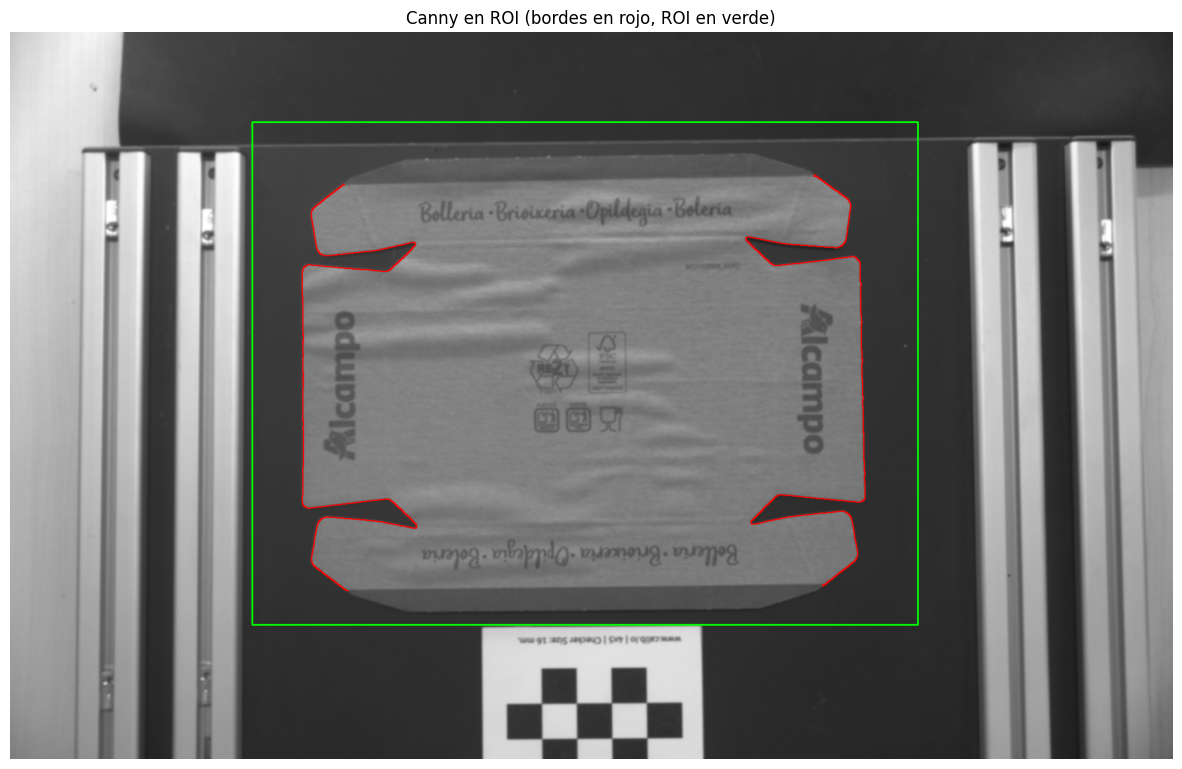

In [69]:
# We distort the image
blur = cv.GaussianBlur(udst_crop_img, (5, 5), 0)

print(blur.shape)

# We define ROI
xl1, yl1, xl2, yl2 = 400, 150, 1500, 980
roi = blur[yl1:yl2, xl1:xl2]

# We apply the canny on the ROI
canny_edges_roi = cv.Canny(roi, 80, 170, L2gradient=True)

print("Borders detected:", np.count_nonzero(canny_edges_roi))

# Dilete the edges
kernel = np.ones((2, 2), np.uint8)
canny_edges = cv.dilate(canny_edges_roi, kernel, iterations=1)

# we make a color copy of the image
img_copy = blur.copy()
img_color_copy = cv.cvtColor(img_copy, cv.COLOR_GRAY2BGR)

# We draw the edges in red on the original image
mask = canny_edges > 0
img_color_copy[yl1:yl2, xl1:xl2][mask] = [0, 0, 255]  # rojo (BGR)

# We draw a rectangle of the ROI in green
cv.rectangle(img_color_copy, (xl1, yl1), (xl2, yl2), (0, 255, 0), 2)

# The results are shown
plt.figure(figsize=(15, 10))
plt.title("Canny en ROI (bordes en rojo, ROI en verde)")
plt.imshow(cv.cvtColor(img_color_copy, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()